<div style="width: 100%; text-align: center">
    <h1>IoT Final Project</h1>
    <h3>Adam Grady<h3>
</div>


In [43]:
# Imports
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import time, datetime, date, timedelta
import numpy as np

## Data Fetching

In [44]:
# Need admin credentials to retrieve from firebase
cred = credentials.Certificate("./admin/admin.json")

if not firebase_admin._apps:
    firebase_admin.initialize_app(cred)

db = firestore.client()

# Ordering the data descending by time
col_ref = db.collection(u'temp').order_by("timestamp", direction=firestore.Query.ASCENDING)
docs = col_ref.stream()

# Mapping the time to the current timezone (Central)
def docify(doc):
    data = doc.to_dict()
    data["timestamp"] = data["timestamp"].astimezone()
    data["time"] = data["timestamp"].time()
    data["minutes"] = (data["time"].hour * 60) + (data["time"].minute) + (data["time"].second / 60)
    return data

formatted = list(map(docify, docs))

# Getting unique days
days = list(set(map(lambda x: x["day"], formatted)))

# Data Plotting

## Line Plots

In [45]:
date_format = mdates.DateFormatter("%I:%M")

<ipython-input-46-5493a2af215e>:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(


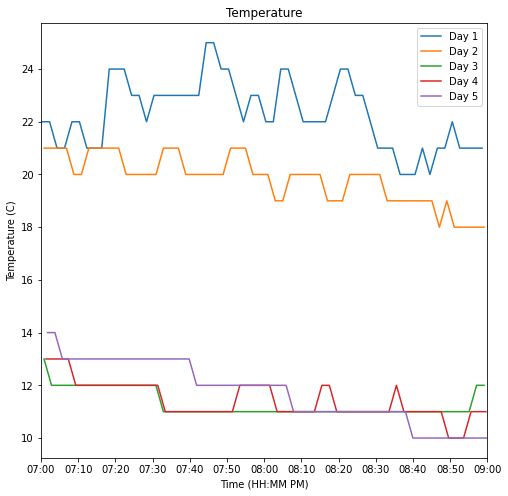

In [46]:
# Temperature
fig, ax = plt.subplots(figsize=(8, 8))
for day in days:
    dayData = list(filter(lambda d: d["day"] == day, formatted))
    ax.plot_date(
        list(map(lambda x: datetime.combine(date.today(), x["time"]), dayData)),
        list(map(lambda x: x["temp"], dayData)),
        marker="",
        ls="-",
        label = "Day " + str(day))
ax.set(
    xlabel = "Time (HH:MM PM)",
    ylabel = "Temperature (C)",
    title = "Temperature",
    xlim=[datetime.combine(date.today(), time(19, 0)), datetime.combine(date.today(), time(21, 0))]
)
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
plt.legend()
plt.show()

<ipython-input-47-b4d1ef757909>:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(


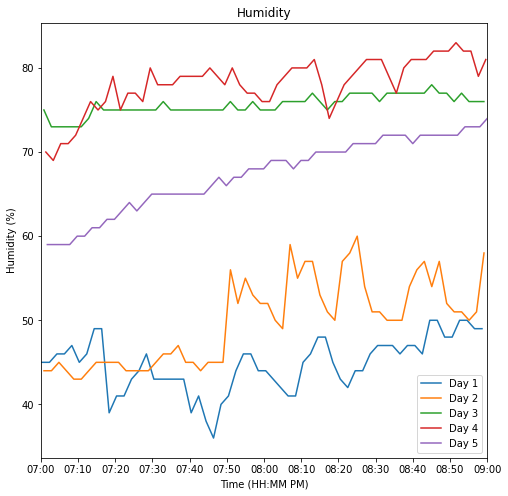

In [47]:
# Humidity
fig, ax = plt.subplots(figsize=(8, 8))
for day in days:
    dayData = list(filter(lambda d: d["day"] == day, formatted))
    ax.plot_date(
        list(map(lambda x: datetime.combine(date.today(), x["time"]), dayData)),
        list(map(lambda x: x["humidity"], dayData)),
        marker="",
        ls="-",
        label = "Day " + str(day))
ax.set(
    xlabel = "Time (HH:MM PM)",
    ylabel = "Humidity (%)",
    title = "Humidity",
    xlim=[datetime.combine(date.today(), time(19, 0)), datetime.combine(date.today(), time(21, 0))]
)
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
plt.legend()
plt.show()

## Box Plots

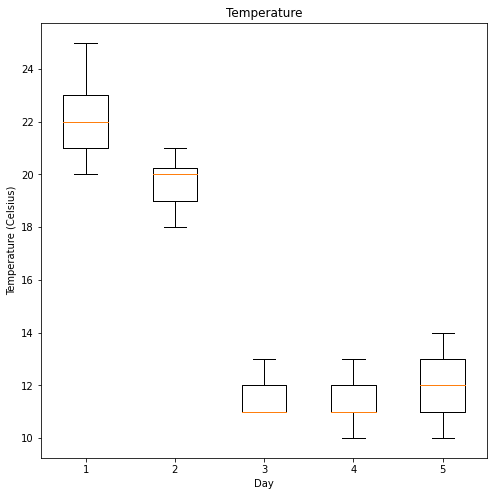

In [48]:
# Temp box plots
tempData =[]
for day in days:
    dayData = list(filter(lambda d: d["day"] == day, formatted))
    tempData.append(list(map(lambda x: x["temp"], dayData)))

plt.figure(figsize=(8, 8))
plt.title("Temperature")
plt.xlabel("Day")
plt.ylabel("Temperature (Celsius)")
plt.boxplot(tempData, labels=days)
plt.show()

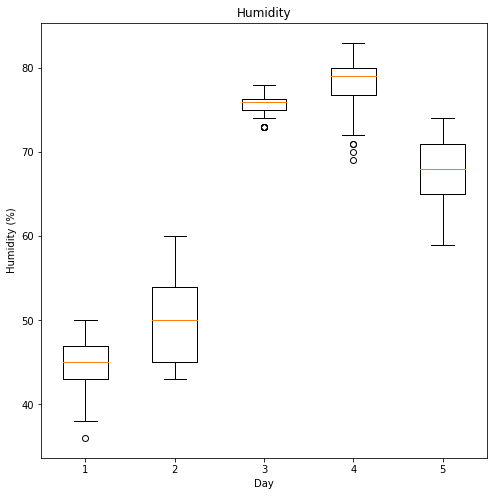

In [49]:
# Humidity box plots
humidityData =[]
for day in days:
    dayData = list(filter(lambda d: d["day"] == day, formatted))
    humidityData.append(list(map(lambda x: x["humidity"], dayData)))

plt.figure(figsize=(8, 8))
plt.title("Humidity")
plt.xlabel("Day")
plt.ylabel("Humidity (%)")
plt.boxplot(humidityData, labels=days)
plt.show()

## Scatter Plot Matrix

array([[<AxesSubplot:xlabel='Temp 1', ylabel='Temp 1'>,
        <AxesSubplot:xlabel='Humidity 1', ylabel='Temp 1'>,
        <AxesSubplot:xlabel='Temp 2', ylabel='Temp 1'>,
        <AxesSubplot:xlabel='Humidity 2', ylabel='Temp 1'>,
        <AxesSubplot:xlabel='Temp 3', ylabel='Temp 1'>,
        <AxesSubplot:xlabel='Humidity 3', ylabel='Temp 1'>],
       [<AxesSubplot:xlabel='Temp 1', ylabel='Humidity 1'>,
        <AxesSubplot:xlabel='Humidity 1', ylabel='Humidity 1'>,
        <AxesSubplot:xlabel='Temp 2', ylabel='Humidity 1'>,
        <AxesSubplot:xlabel='Humidity 2', ylabel='Humidity 1'>,
        <AxesSubplot:xlabel='Temp 3', ylabel='Humidity 1'>,
        <AxesSubplot:xlabel='Humidity 3', ylabel='Humidity 1'>],
       [<AxesSubplot:xlabel='Temp 1', ylabel='Temp 2'>,
        <AxesSubplot:xlabel='Humidity 1', ylabel='Temp 2'>,
        <AxesSubplot:xlabel='Temp 2', ylabel='Temp 2'>,
        <AxesSubplot:xlabel='Humidity 2', ylabel='Temp 2'>,
        <AxesSubplot:xlabel='Temp 3', ylabel='

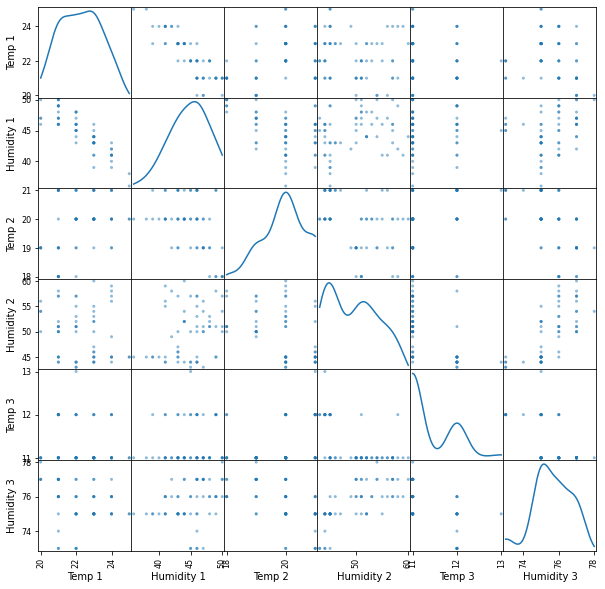

In [50]:
df = pd.DataFrame()

# Taking first 3 days
for day in days[:3]:
    dayData = list(filter(lambda d: d["day"] == day, formatted))
    dayData_temp = list(map(lambda x: x["temp"], dayData))
    dayData_humidity = list(map(lambda x: x["humidity"], dayData))
    df["Temp " + str(day)] = list(map(lambda x: x["temp"], dayData))
    df["Humidity " + str(day)] = list(map(lambda x: x["humidity"], dayData))

pd.plotting.scatter_matrix(df, diagonal="kde", figsize=(10, 10))

# Data Analysis

In [51]:
import sklearn.linear_model as lm
import sklearn.metrics as metrics

df = pd.DataFrame.from_dict(formatted)

### Model 1 - Temperature & Minutes

<AxesSubplot:>

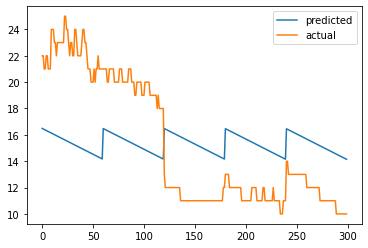

In [52]:
X = df.minutes.values.reshape(-1, 1)
M1_y = df.temp.values

M1 = lm.LinearRegression()
M1.fit(X, M1_y)

M1_pred = M1.predict(X)
p = pd.DataFrame({ "predicted": M1_pred, "actual": M1_y })
p.plot()

### Model 2 - Humidity & Minutes

<AxesSubplot:>

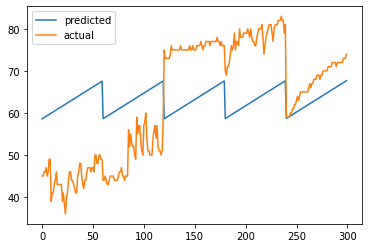

In [53]:
X = df.minutes.values.reshape(-1, 1)
M2_y = df.humidity.values

M2 = lm.LinearRegression()
M2.fit(X, M2_y)

M2_pred = M2.predict(X)
p = pd.DataFrame({ "predicted": M2_pred, "actual": M2_y })
p.plot()

### Model 3 - Temperature, Humidity & Minutes

<AxesSubplot:>

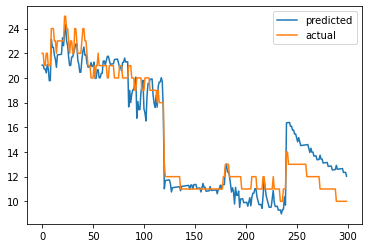

In [54]:
X = df[["minutes", "humidity"]]
M3_y = df.temp.values

M3 = lm.LinearRegression()
M3.fit(X, M3_y)

M3_pred = M3.predict(X)
p = pd.DataFrame({ "predicted": M3_pred, "actual": M3_y })
p.plot()

### Mean Squared Error

In [57]:
print("M1: " + str(metrics.mean_squared_error(M1_y, M1_pred)))

print("M2: " + str(metrics.mean_squared_error(M2_y, M2_pred)))

print("M3: " + str(metrics.mean_squared_error(M3_y, M3_pred)))

M1: 23.041231448998897
M2: 188.65467947610466
M3: 2.0004927296027826


### AIC

In [58]:
# AIC = 2k - 2ln(sse)

M1_sse = sum((M1_y - M1_pred) ** 2)
M1_aic = 2*1 - 2*np.log(M1_sse)
print("M1: " + str(M1_aic))

M2_sse = sum((M2_y - M2_pred) ** 2)
M2_aic = 2*1 - 2*np.log(M2_sse)
print("M2: " + str(M2_aic))

M3_sse = sum((M3_y - M3_pred) ** 2)
M3_aic = 2*2 - 2*np.log(M3_sse)
print("M3: " + str(M3_aic))


M1: -15.682135514725651
M2: -19.88740145165404
M3: -8.794351979349427
